In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/file.zip

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python
!pip install opencv-python

In [ ]:
!pip install tensorflow==2.3.1

In [1]:
import pandas as pd
train_df=pd.read_csv("/content/MetaData_Release_1.0.csv")

In [5]:
train_df

,File Name,Class,Microns Per Pixel,Magnification,The Number of Pyramid Levels in Tiff,Level[0] Downsampling Factor,Level[0] Image Width (Pixels),Level[0] Image Height (Pixels),Level[0] Tile Image Width (Pixels),Level[0] Tile Image Height (Pixels),Level[1] Downsampling Factor,Level[1] Image Width (Pixels),Level[1] Image Height (Pixels),Level[1] Tile Image Width (Pixels),Level[1] Tile Image Height (Pixels),Level[2] Downsampling Factor,Level[2] Image Width (Pixels),Level[2] Image Height (Pixels),Level[2] Tile Image Width (Pixels),Level[2] Tile Image Height (Pixels),Level[3] Downsampling Factor,Level[3] Image Width (Pixels),Level[03 Image Height (Pixels),Level[3] Tile Image Width (Pixels),Level[3] Tile Image Height (Pixels),Level[4] Downsampling Factor,Level[4] Image Width (Pixels),Level[4] Image Height (Pixels),Level[4] Tile Image Width (Pixels),Level[4] Tile Image Height (Pixels),Level[5] Downsampling Factor,Level[5] Image Width (Pixels),Level[5] Image Height (Pixels),Level[5] Tile Image Width (Pixels),Level[5] Tile Image Height (Pixels),Level[6] Downsampling Factor,Level[6] Image Width (Pixels),Level[6] Image Height (Pixels),Level[6] Tile Image Width (Pixels),Level[6] Tile Image Height (Pixels),Level[7] Downsampling Factor,Level[7] Image Width (Pixels),Level[7] Image Height (Pixels),Level[7] Tile Image Width (Pixels),Level[7] Tile Image Height (Pixels),Level[8] Downsampling Factor,Level[8] Image Width (Pixels),Level[8] Image Height (Pixels),Level[8] Tile Image Width (Pixels),Level[8] Tile Image Height (Pixels),Level[9] Downsampling Factor,Level[9] Image Width (Pixels),Level[9] Image Height (Pixels),Level[9] Tile Image Width (Pixels),Level[9] Tile Image Height (Pixels),Level[10] Downsampling Factor,Level[10] Image Width (Pixels),Level[10] Image Height (Pixels),Level[10] Tile Image Width (Pixels),Level[10] Tile Image Height (Pixels)
0,DHMC_0001.tif,solid,0.5028,20,9,1,39839,30468,240,240,2.000025,19919,15234,240,240,4.000151,9959,7617,240,240,8.001228,4979,3808,240,240,16.004064,2489,1904,240,240,32.014561,1244,952,240,240,64.029121,622,476,240,240,128.058243,311.0,238.0,240.0,240.0,256.529710,155.0,119.0,240.0,240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DHMC_0002.tif,solid,0.5038,20,8,1,49800,25855,512,512,2.000039,24900,12927,512,512,4.000232,12450,6463,512,512,8.001083,6225,3231,512,512,16.005929,3112,1615,512,512,32.021778,1556,807,512,512,64.083305,778,403,512,512,128.326203,389.0,201.0,512.0,512.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DHMC_0003.tif,solid,0.5038,20,8,1,45816,26741,512,512,2.000037,22908,13370,512,512,4.000075,11454,6685,512,512,8.000748,5727,3342,512,512,16.002893,2863,1671,512,512,32.020961,1431,835,512,512,64.102710,715,417,512,512,128.449317,357.0,208.0,512.0,512.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DHMC_0004.tif,solid,0.5038,20,8,1,45816,26097,512,512,2.000038,22908,13048,512,512,4.000077,11454,6524,512,512,8.000153,5727,3262,512,512,16.001704,2863,1631,512,512,32.018815,1431,815,512,512,64.099357,715,407,512,512,128.446392,357.0,203.0,512.0,512.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DHMC_0005.tif,lepidic,0.5038,20,8,1,31872,33269,512,512,2.000030,15936,16634,512,512,4.000060,7968,8317,512,512,8.000601,3984,4158,512,512,16.001203,1992,2079,512,512,32.010106,996,1039,512,512,64.051060,498,519,512,512,128.225869,249.0,259.0,512.0,512.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,DHMC_0139.tif,micropapillary,0.5028,20,9,1,49800,37115,240,240,2.000027,24900,18557,240,240,4.000162,12450,9278,240,240,8.000323,6225,4639,240,240,16.003657,3112,2319,240,240,32.014219,1556,1159,240,240,64.056091,778,579,240,240,128.223086,389.0,289.0,240.0,240.0,257.222043,194.0,144.0,240.0,24

In [6]:
!mkdir wsi_train
!mkdir wsi_train/solid
!mkdir wsi_train/lepidic
!mkdir wsi_train/micropapillary
!mkdir wsi_train/papillary
!mkdir wsi_train/acinar

In [7]:
train_df["File Name"]

0      DHMC_0001.tif
1      DHMC_0002.tif
2      DHMC_0003.tif
3      DHMC_0004.tif
4      DHMC_0005.tif
           ...      
138    DHMC_0139.tif
139    DHMC_0140.tif
140    DHMC_0141.tif
141    DHMC_0142.tif
142    DHMC_0143.tif
Name: File Name, Length: 143, dtype: object

In [ ]:
for i in range(len(train_df["Class"])):
  src_path="/content/" + train_df["File Name"][i]

  if train_df["Class"][i]=="solid":
    des_path="/content/wsi_train/solid/"
    !mv $src_path $des_path

  elif train_df["Class"][i]=="lepidic":
    des_path="/content/wsi_train/lepidic/"
    !mv $src_path $des_path
  elif train_df["Class"][i]=="micropapillary":  
    des_path="/content/wsi_train/micropapillary/"
    !mv $src_path $des_path
  elif train_df["Class"][i]=="papillary":
    des_path="/content/wsi_train/papillary/"
    !mv $src_path $des_path
  elif train_df["Class"][i]=="acinar":
    des_path="/content/wsi_train/acinar/"
    !mv $src_path $des_path

In [9]:
import os
solid_training_path_list=os.listdir("/content/wsi_train/solid")
lepidic_training_path_list=os.listdir("/content/wsi_train/lepidic")
micropapillary_training_path_list=os.listdir("/content/wsi_train/micropapillary")
papillary_training_path_list=os.listdir("/content/wsi_train/papillary")
acinar_training_path_list=os.listdir("/content/wsi_train/acinar")

In [10]:
solid_training_path_list

['DHMC_0122.tif',
 'DHMC_0140.tif',
 'DHMC_0129.tif',
 'DHMC_0126.tif',
 'DHMC_0132.tif',
 'DHMC_0125.tif',
 'DHMC_0128.tif',
 'DHMC_0143.tif']

In [11]:
lepidic_training_path_list

['DHMC_0124.tif']

In [12]:
micropapillary_training_path_list

['DHMC_0139.tif', 'DHMC_0137.tif']

In [13]:
papillary_training_path_list

['DHMC_0141.tif', 'DHMC_0135.tif']

In [14]:
acinar_training_path_list

['DHMC_0131.tif',
 'DHMC_0127.tif',
 'DHMC_0142.tif',
 'DHMC_0136.tif',
 'DHMC_0123.tif',
 'DHMC_0138.tif',
 'DHMC_0134.tif',
 'DHMC_0133.tif',
 'DHMC_0120.tif',
 'DHMC_0130.tif',
 'DHMC_0121.tif']

In [15]:
!mkdir train_folder
!mkdir train_folder/train

In [17]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

import os
import numpy as np
%matplotlib inline

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np


## Must be openslide version 3.4.1
from openslide import open_slide, __library_version__ as openslide_version
print(openslide_version)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

3.4.1


In [21]:
import tensorflow as tf


import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from skimage.color import rgb2gray
import cv2
import os
import random
import pathlib
import openslide
import PIL
from PIL import Image
from openslide.lowlevel import *
from openslide.lowlevel import _convert


def _load_image_lessthan_2_29(buf, size):
    '''buf must be a mutable buffer.'''
    _convert.argb2rgba(buf)
    return PIL.Image.frombuffer('RGBA', size, buf, 'raw', 'RGBA', 0, 1)


def _load_image_morethan_2_29(buf, size):
    '''buf must be a buffer.'''

    # Load entire buffer at once if possible
    MAX_PIXELS_PER_LOAD = (1 << 29) - 1
    # Otherwise, use chunks smaller than the maximum to reduce memory
    # requirements
    PIXELS_PER_LOAD = 1 << 26

    def do_load(buf, size):
        '''buf can be a string, but should be a ctypes buffer to avoid an
        extra copy in the caller.'''
        # First reorder the bytes in a pixel from native-endian aRGB to
        # big-endian RGBa to work around limitations in RGBa loader
        rawmode = (sys.byteorder == 'little') and 'BGRA' or 'ARGB'
        buf = PIL.Image.frombuffer('RGBA', size, buf, 'raw', rawmode, 0, 1)
        # Image.tobytes() is named tostring() in Pillow 1.x and PIL
        buf = (getattr(buf, 'tobytes', None) or buf.tostring)()
        # Now load the image as RGBA, undoing premultiplication
        return PIL.Image.frombuffer('RGBA', size, buf, 'raw', 'RGBa', 0, 1)

    # Fast path for small buffers
    w, h = size
    if w * h <= MAX_PIXELS_PER_LOAD:
        return do_load(buf, size)

    # Load in chunks to avoid OverflowError in PIL.Image.frombuffer()
    # https://github.com/python-pillow/Pillow/issues/1475
    if w > PIXELS_PER_LOAD:
        # We could support this, but it seems like overkill
        raise ValueError('Width %d is too large (maximum %d)' %
                         (w, PIXELS_PER_LOAD))
    rows_per_load = PIXELS_PER_LOAD // w
    img = PIL.Image.new('RGBA', (w, h))
    for y in range(0, h, rows_per_load):
        rows = min(h - y, rows_per_load)
        if sys.version[0] == '2':
            chunk = buffer(buf, 4 * y * w, 4 * rows * w)
        else:
            # PIL.Image.frombuffer() won't take a memoryview or
            # bytearray, so we can't avoid copying
            chunk = memoryview(buf)[y * w:(y + rows) * w].tobytes()
        img.paste(do_load(chunk, (w, rows)), (0, y))
    return img


def read_slide(slide, x, y, level, width, height, as_float=False):

    # Reading the slides and converting them into a RGB numpy array
    openslide.lowlevel._load_image = _load_image_morethan_2_29
    im = slide.read_region((x, y), level, (width, height))
    im = im.convert('RGB')  # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im


def find_tissue_pixels(image, intensity=0.8):

    # Finding the pixels having value less than or equal to the intensity value
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])


def apply_mask(im, mask, color=1):

    # Applies the mask to the slides image
    masked = np.zeros((im.shape[0], im.shape[1]))
    for x, y in mask:
        masked[x][y] = color
    return masked


# This function makes the directories required during testing
def initialize_directories_test(slide_path, level):

    BASE_DIR = os.getcwd()

    img_num = slide_path[-13:-4]

    DATA = 'train_folder/'
    TRAIN="train/"
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = 'level_'+str(level)+'/'
    TISSUE_FOLDER = 'tissue_only/'
    ALL_FOLDER = 'all/'

    DATA_DIR = os.path.join(BASE_DIR, DATA)
    TRAIN_DIR = os.path.join(BASE_DIR, DATA,TRAIN)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA,TRAIN, IMG_NUM_FOLDER)
    LEVEL_NUM_DIR = os.path.join(BASE_DIR, DATA,TRAIN, IMG_NUM_FOLDER, LEVEL_FOLDER)
    TISSUE_DIR = os.path.join(BASE_DIR, DATA,TRAIN, IMG_NUM_FOLDER, LEVEL_FOLDER, TISSUE_FOLDER)
    ALL_DIR = os.path.join(BASE_DIR, DATA,TRAIN, IMG_NUM_FOLDER, LEVEL_FOLDER, ALL_FOLDER)

    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(TRAIN_DIR):
        os.mkdir(TRAIN_DIR)    
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(LEVEL_NUM_DIR):
        os.mkdir(LEVEL_NUM_DIR)
    if not os.path.exists(TISSUE_DIR):
        os.mkdir(TISSUE_DIR)
    if not os.path.exists(ALL_DIR):
        os.mkdir(ALL_DIR)

    return DATA + TRAIN + IMG_NUM_FOLDER + LEVEL_FOLDER + TISSUE_FOLDER, DATA + TRAIN + IMG_NUM_FOLDER + LEVEL_FOLDER + ALL_FOLDER


# This function is used to create the directories during training
def initialize_directories(slide_path, level):
    BASE_DIR = os.getcwd()

    img_num = slide_path.split('_')[1].strip(".tiff")

    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = 'level_'+str(level)+'/'
    TUMOR_FOLDER = 'tumor/'
    NO_TUMOR_FOLDER = 'no_tumor/'

    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    LEVEL_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER)
    TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TUMOR_FOLDER)
    NO_TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, NO_TUMOR_FOLDER)

    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(LEVEL_NUM_DIR):
        os.mkdir(LEVEL_NUM_DIR)
    if not os.path.exists(TUMOR_DIR):
        os.mkdir(TUMOR_DIR)
    if not os.path.exists(NO_TUMOR_DIR):
        os.mkdir(NO_TUMOR_DIR)

    return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TUMOR_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + NO_TUMOR_FOLDER


# Save the image as tissue or not
def split_image_test(im, tissue_mask, num_pixels, level_num, slide_path):
    x, y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y / num_pixels))

    tissue_folder, all_folder = initialize_directories_test(slide_path, level_num)

    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                im_tissue_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))

                string_name = 'img_' + str(i * y_count + j)

                # Logic to handle the edges of the images
                if i == x_count - 1:
                    ub_x = x
                    assign_x = x - (x_count - 1) * num_pixels
                else:
                    ub_x = (i + 1) * num_pixels
                    assign_x = num_pixels

                if j == y_count - 1:
                    ub_y = y
                    assign_y = y - (y_count - 1) * num_pixels
                else:
                    ub_y = (j + 1) * num_pixels
                    assign_y = num_pixels

                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i * num_pixels):ub_x, (j * num_pixels):ub_y]

                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_tissue_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                        im_file_name_tissue = tissue_folder + string_name + ".jpg"
                        cv2.imwrite(im_file_name_tissue, im_tissue_slice)

                    im_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                    im_file_name_all = all_folder + string_name + ".jpg"
                    cv2.imwrite(im_file_name_all, im_slice)

                except Exception as oerr:
                    print('Error with saving:', oerr)

    except Exception as oerr:
        print('Error with slicing:', oerr)



import tensorflow as tf


import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from skimage.color import rgb2gray
import cv2
import os
import random
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Load and preprocess image.
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

#Preprocess image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range

    return image



def load_image(slide_path):

    # Loading the slide image and the tumor mask image
    slide = open_slide(slide_path)
  
    
    # Checking if the dimensions of the mask image and the slide image match or not
  
    print(slide.level_dimensions)
    print("---",slide.level_downsamples[2],slide.level_dimensions[2][0])
    # Verify downsampling works as expected
    width, height = slide.level_dimensions[2]
    print(width,height)
    #assert width * slide.level_downsamples[2] == slide.level_dimensions[2][0]
    #assert height * slide.level_downsamples[2] == slide.level_dimensions[0][1]

    return slide

In [19]:
def test_part_1(testing_image_path, num_pixels=64, num_level=2):

    slide_path_test = testing_image_path
  
    print(slide_path_test)

    # Retrieve slide parameters before overwriting
    slide = load_image(slide_path_test)
    width, height = slide.level_dimensions[num_level][0], slide.level_dimensions[num_level][1]

    # Read training image at slide level 3
    slide = read_slide(slide,
                       x=0,
                       y=0,
                       level=num_level,
                       width=width,
                       height=height)

    

    # Retrieve new array dimensions
    image_depth, image_width = int(np.ceil(slide.shape[0] / num_pixels)), int(np.ceil(slide.shape[1] / num_pixels))

    

    # Determine the portions of the image that are tissue
    tissue_pixels = list(find_tissue_pixels(slide))

    # Turn the tissue pixels into a mask
    tissue_regions = apply_mask(slide, tissue_pixels)

    split_image_test(slide, tissue_regions, num_pixels, num_level, slide_path_test)
    return image_depth, image_width, tissue_regions, slide

In [20]:
# testing_image_path_list = ['/content/wsi_train/acinar/DHMC_0121.tif']


# image_depth, image_width, tissue_regions, slide_image_test = test_part_1(testing_image_path_list[0] ,
#                                                                           num_pixels=128,
#                                                                           num_level = 2)


/content/wsi_train/acinar/DHMC_0121.tif
((41831, 23507), (20915, 11753), (10457, 5876), (5228, 2938), (2614, 1469), (1307, 734), (653, 367), (326, 183), (163, 91))
--- 4.00039872028033 10457
10457 5876


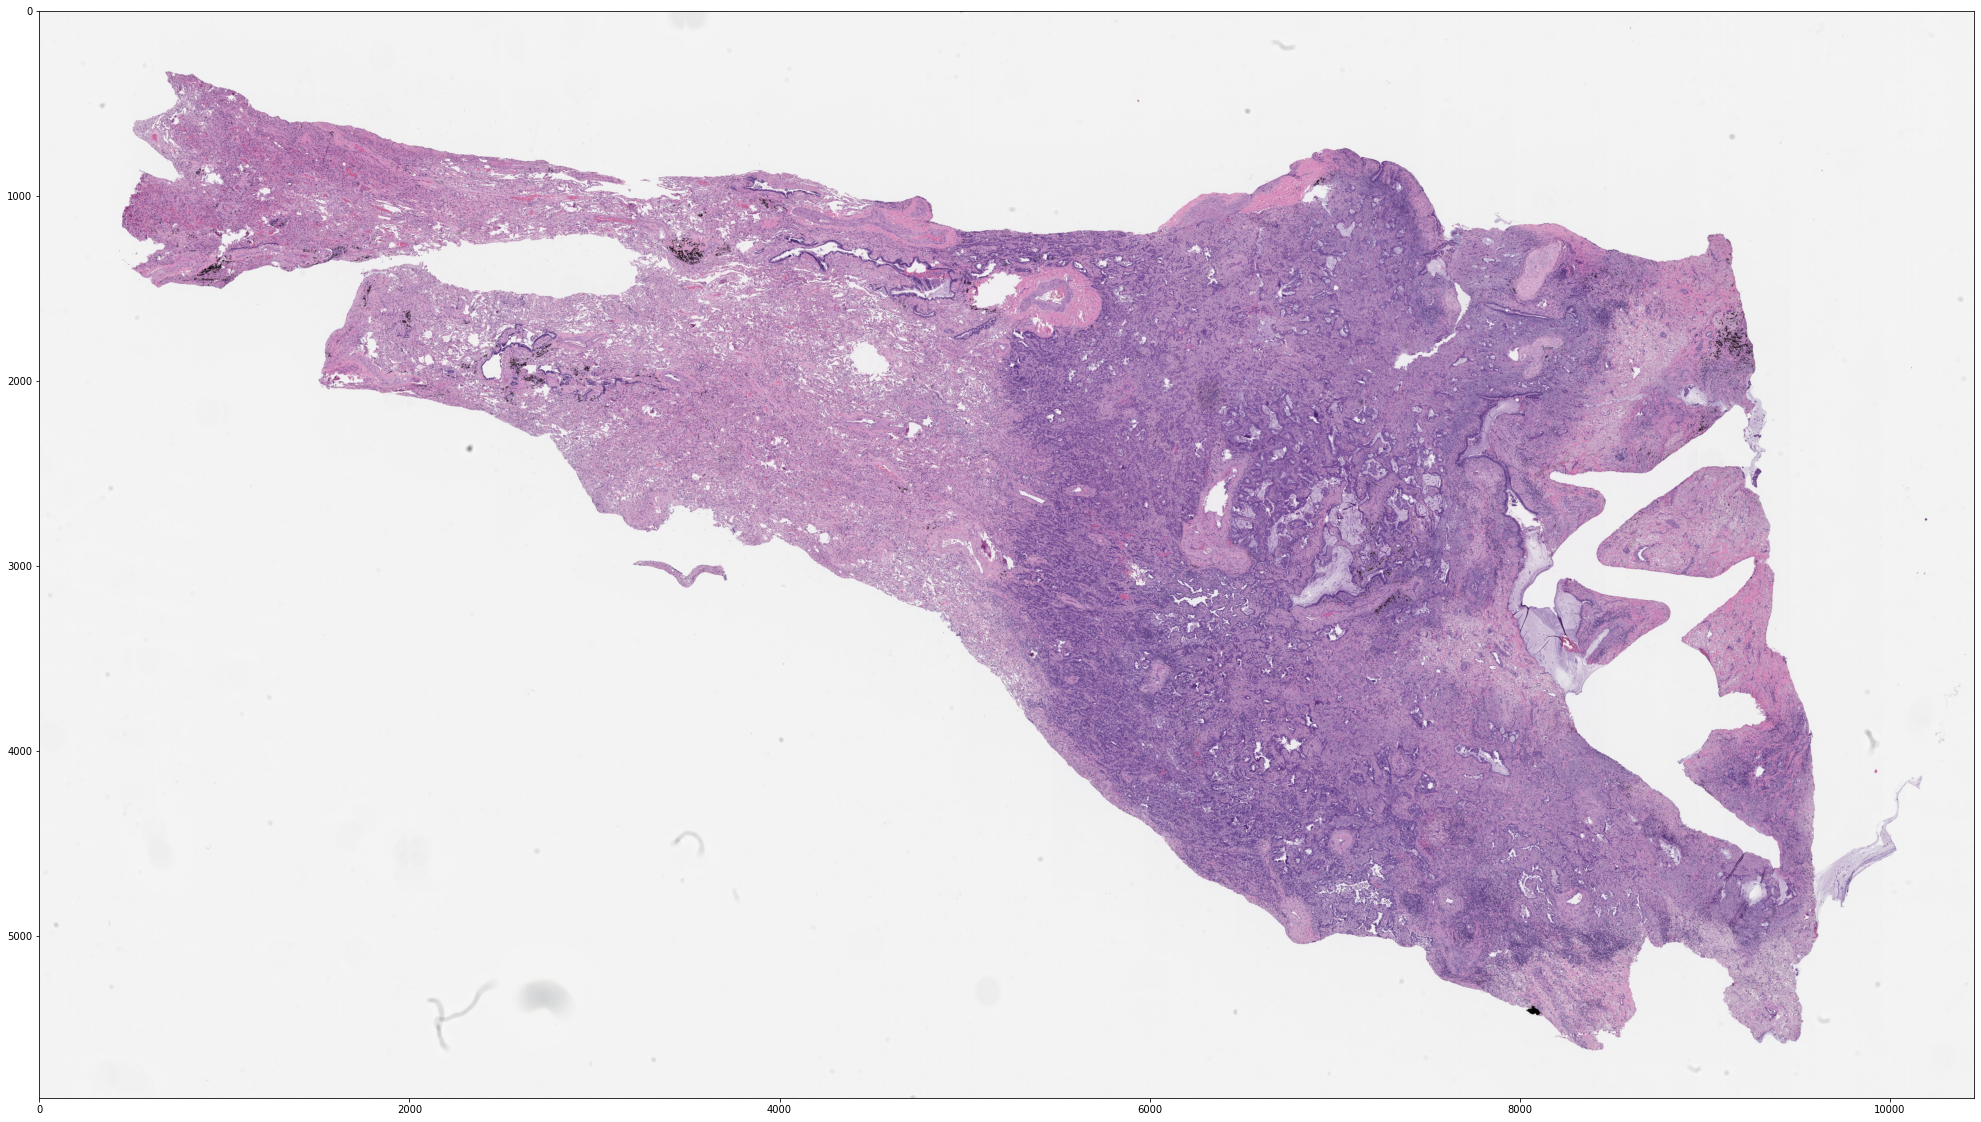

In [26]:
import matplotlib
plt.figure(figsize=(50,20))
plt.imshow(slide_image_test)


In [28]:
solid_training_path_list

['DHMC_0122.tif',
 'DHMC_0140.tif',
 'DHMC_0129.tif',
 'DHMC_0126.tif',
 'DHMC_0132.tif',
 'DHMC_0125.tif',
 'DHMC_0128.tif',
 'DHMC_0143.tif']

In [ ]:
# import os
# solid_training_path_list=os.listdir("/content/wsi_train/solid")
# lepidic_training_path_list=os.listdir("/content/wsi_train/lepidic")
# micropapillary_training_path_list=os.listdir("/content/wsi_train/micropapillary")
# papillary_training_path_list=os.listdir("/content/wsi_train/papillary")
# acinar_training_path_list=os.listdir("/content/wsi_train/acinar")

In [ ]:
for i in range(len(solid_training_path_list)):
  file_path="/content/wsi_train/solid/" + solid_training_path_list[i]
  image_depth, image_width, tissue_regions, slide_image_test = test_part_1(file_path,
                                                                           num_pixels=128,
                                                                           num_level = 2)


/content/wsi_train/solid/DHMC_0122.tif
((33864, 34040), (16932, 17020), (8466, 8510), (4233, 4255), (2116, 2127), (1058, 1063), (529, 531), (264, 265), (132, 132))
--- 4.0 8466
8466 8510
/content/wsi_train/solid/DHMC_0140.tif
((45815, 35914), (22907, 17957), (11453, 8978), (5726, 4489), (2863, 2244), (1431, 1122), (715, 561), (357, 280), (178, 140))
--- 4.000242353433114 11453
11453 8978
/content/wsi_train/solid/DHMC_0129.tif
((33864, 40823), (16932, 20411), (8466, 10205), (4233, 5102), (2116, 2551), (1058, 1275), (529, 637), (264, 318), (132, 159))
--- 4.00014698677119 8466
8466 10205
/content/wsi_train/solid/DHMC_0126.tif
((29879, 28741), (14939, 14370), (7469, 7185), (3734, 3592), (1867, 1796), (933, 898), (466, 449), (233, 224))
--- 4.000270419520145 7469
7469 7185
/content/wsi_train/solid/DHMC_0132.tif
((55776, 42145), (27888, 21072), (13944, 10536), (6972, 5268), (3486, 2634), (1743, 1317), (871, 658), (435, 329), (217, 164))
--- 4.000047456340167 13944
13944 10536


In [17]:
import os
len(os.listdir("train_folder/train/DHMC_0122/level_2/tissue_only"))

1340

In [18]:
len(os.listdir("train_folder/train/DHMC_0122/level_2/all"))

0

In [6]:
!ls train_folder/train/DHMC_0140/level_2/tissue_only  

img_1032.jpg  img_1831.jpg  img_2567.jpg  img_3437.jpg	img_4250.jpg
img_1033.jpg  img_1832.jpg  img_2568.jpg  img_3438.jpg	img_4251.jpg
img_1034.jpg  img_1833.jpg  img_2569.jpg  img_3439.jpg	img_4254.jpg
img_1035.jpg  img_1834.jpg  img_256.jpg   img_343.jpg	img_4256.jpg
img_1036.jpg  img_1835.jpg  img_2570.jpg  img_3440.jpg	img_4257.jpg
img_1037.jpg  img_1836.jpg  img_2571.jpg  img_3441.jpg	img_4258.jpg
img_1038.jpg  img_1837.jpg  img_2572.jpg  img_3442.jpg	img_4260.jpg
img_1039.jpg  img_1838.jpg  img_2573.jpg  img_3443.jpg	img_4261.jpg
img_1040.jpg  img_1839.jpg  img_2579.jpg  img_3444.jpg	img_4262.jpg
img_1041.jpg  img_1840.jpg  img_257.jpg   img_3445.jpg	img_4263.jpg
img_1042.jpg  img_1841.jpg  img_2580.jpg  img_3446.jpg	img_4264.jpg
img_1043.jpg  img_1842.jpg  img_2591.jpg  img_3447.jpg	img_4269.jpg
img_1045.jpg  img_1843.jpg  img_2616.jpg  img_3448.jpg	img_4273.jpg
img_1051.jpg  img_1844.jpg  img_2617.jpg  img_3449.jpg	img_4275.jpg
img_1063.jpg  img_1845.jpg  img_2618.jpg  img_344